[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.07       -0.06994978 -0.06990006 ...  0.          0.
  0.        ]


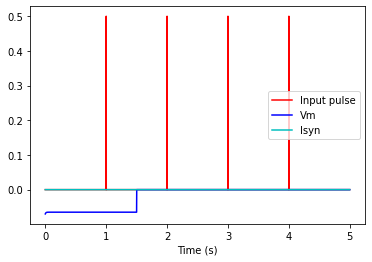

In [1]:
#single LIF neuron- sequential synaptic input using class SeqSynHandler


import sys
import os
import moose
import matplotlib.pyplot as plt
import numpy as np

def setupmodel(modelpath, iaf_Rm, iaf_Cm, pulse_interval):
    model_container = moose.Neutral(modelpath)
    data_container = moose.Neutral(datapath)
    iaf = moose.LIF('%s/iaf' % (modelpath))
    iaf.Rm = iaf_Rm
    iaf.Cm = iaf_Cm
    iaf.initVm = -0.070
    iaf.Em = -0.065
    #iaf.Vreset = -0.070
    iaf.thresh = -0.055
    iaf.refractoryPeriod = 0.005

    syn = moose.SynChan('%s/syn' % (iaf.path))
    synh = moose.SeqSynHandler( syn.path + '/synh')
    for i in synh.vec:
        i.kernelEquation = "(x == t) "
    synh.vec.kernelWidth = 4
    synh.vec.historyTime = 5
    synh.vec.sequenceScale = 0.001
    synh.vec.plasticityScale = 0.0
    synh.vec.seqDt = 0.5
    v = synh.kernel 
    print(v)

    moose.connect(synh, 'activationOut', syn, 'activation')



    synh.synapse.num = 4
    synh.synapse[0].delay = 0.01
    syn.Ek = 0.0
    syn.Gbar = 1.0
    moose.connect(syn, 'channel', iaf, 'channel')
    moose.connect(iaf, 'VmOut', syn, 'Vm')
    sg = moose.SpikeGen('%s/spike' % (modelpath))
    sg.threshold = 0.1
    moose.connect(sg, 'spikeOut', synh.synapse[0], 'addSpike')
    
    pulse = moose.PulseGen('%s/pulse' % (modelpath))
    pulse.count = 4
    pulse_interval = 1
    for i in range(0,3):
        pulse.delay[i] = pulse_interval 
        pulse.width[i] = 1e-3
        pulse.level[i] = 0.5
    moose.connect(pulse, 'output', sg, 'Vm')
    return {
        'model': model_container,
        'iaf': iaf,
        'synchan': syn,
        'spikegen': sg,
        'pulsegen': pulse
        }

if __name__ == '__main__':
    modelpath = '/lif_demo'
    datapath = '/data'
    simtime = 5.0
    setup = setupmodel(modelpath, 127e6, 7.8e-11, 0.1)
    
    # Setup data recording
    data_container = moose.Neutral(datapath)
    vm_table = moose.Table('%s/vm' % (data_container.path))
    
    moose.connect(vm_table, 'requestOut', setup['iaf'], 'getVm')
    spike_table = moose.Table('%s/spike' % (data_container.path))

    pulse_table = moose.Table('%s/pulse' % (data_container.path))
    moose.connect(pulse_table, 'requestOut', setup['pulsegen'], 'getOutputValue')
    
    gsyn_table = moose.Table('%s/gk' % (datapath))
    moose.connect(gsyn_table, 'requestOut', setup['synchan'], 'getIk')
    
    # Schedule model components for simulation
    moose.setClock(0, 1e-4)
    moose.setClock(1, 1e-4)
    moose.setClock(2, 1e-4)
    moose.setClock(3, 1e-4)
    moose.useClock(0, '%s,%s' % (setup['pulsegen'].path, setup['spikegen'].path), 'process')
    moose.useClock(1, setup['synchan'].path, 'process')
    moose.useClock(2, setup['iaf'].path, 'process')
    moose.useClock(3, '%s/##' % (datapath), 'process')
    
    #run simulation
    moose.reinit()
    moose.start(simtime)
    t = np.linspace(0, simtime, len(pulse_table.vector))
    plt.plot(t, pulse_table.vector, 'r', label='Input pulse')
    plt.plot(t, vm_table.vector, 'b', label='Vm')
    print(vm_table.vector)
    plt.plot(t, gsyn_table.vector, 'c', label='Isyn')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.show()